In [1]:
import math, h5py, scipy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from kerastuner.tuners import Hyperband
import keras_tuner as kt
# from keras.callbacks import EarlyStopping

C:\Users\moham\AppData\Local\Temp\ipykernel_27236\1664567409.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


Set GPU

In [2]:
# Check GPU
physical_devices = tf.config.list_physical_devices('GPU')
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.98)
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

Load Data

In [3]:
from DataLoader import DataLoader
data_loader = DataLoader("dataset_31.hdf5")
data_loader.divide_data(train_percentage=0.6, valid_percentage=0.2, test_percentage=0.2)

x_train, y_train = data_loader.get_train_data_fn()
x_valid, y_valid,_ = data_loader.get_validation_data()

# train = h5py.File('train.hdf5', 'r')
# valid = h5py.File('valid.hdf5', 'r')
# x_train = train['frames'][:]
# y_train = train['contact'][:]
# x_valid = valid['frames'][:]
# y_valid = valid['contact'][:]

In [4]:
x_valid.shape

(196, 260, 346, 6)

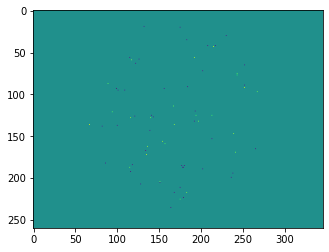

In [6]:
# Frame before re-sizing

import matplotlib.pyplot as plt
plt.imshow(x_train[2, :, :, 5])

In [7]:
# resize images array 
# original shape is (260, 346, 3) == convert to (130, 173, 3)
def resize_images(image_arrays, size=[130, 173], n_channels=3):
    image_arrays = (image_arrays).astype('uint8')

    resized_image_arrays = np.zeros([image_arrays.shape[0]] + size + [n_channels])
    print (resized_image_arrays.shape)
    for i, image_array in enumerate(image_arrays):
        image = Image.fromarray(image_array[:,:,1:4])
        resized_image = image.resize(size=[173, 130])
        resized_image_arrays[i] = resized_image

    return resized_image_arrays


In [8]:

x_train = resize_images(x_train, n_channels=3)
x_valid = resize_images(x_valid, n_channels=3)

input_shape = x_train.shape[1:4]

(981, 130, 173, 3)
(196, 130, 173, 3)


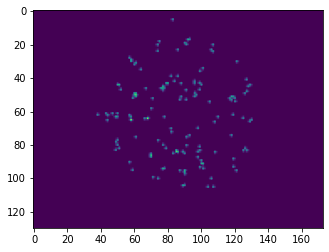

In [9]:
# Frame after re-sizing
plt.imshow(x_train[2,:,:,2])

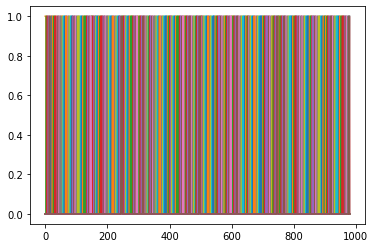

In [66]:
plt.plot(y_train)

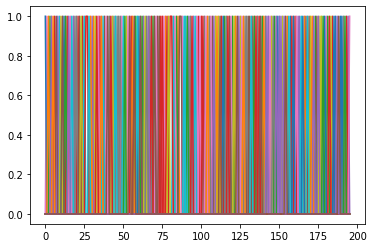

In [67]:
plt.plot(y_valid)

# Training

Load Model

In [10]:
# custom activation function (softmax)
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def custom_activation(x):
    a = 1 + ...
    return np.exp(a*x) / np.sum(np.exp(a*x), axis=0)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [11]:
from Model_II import m1, m2, m3, m4, m5, m6, xception_model, vgg16_model, vgg19_model, ResNet50_model, InceptionV3_model, DenseNet201_model
input_shape = x_train.shape[1:4]
print(input_shape)
model = m3(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

file_name = 'm3_130x173_512x16_DATASET_3'


(130, 173, 3)


Train Model

In [16]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks_list = [early_stopping]

history = model.fit(
                x_train, y_train, 
                epochs = 512,
                batch_size = 32,
                validation_data = (x_valid, y_valid),
                callbacks = callbacks_list,
                shuffle=True)

Epoch 1/512
31/31 [==============================] - 3s 105ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 2.0043e-04 - val_accuracy: 1.0000
Epoch 2/512
31/31 [==============================] - 3s 105ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 3.0996e-04 - val_accuracy: 1.0000
Epoch 3/512
31/31 [==============================] - 3s 105ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 1.3923e-04 - val_accuracy: 1.0000
Epoch 4/512
31/31 [==============================] - 3s 105ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0720e-04 - val_accuracy: 1.0000
Epoch 5/512
31/31 [==============================] - 3s 106ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 9.3134e-05 - val_accuracy: 1.0000
Epoch 6/512
31/31 [==============================] - 3s 106ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 9.4303e-05 - val_accuracy: 1.0000
Epoch 7/512
31/31 [==============================] - 3s 106ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 8.086

In [17]:
# Save trained model
location = 'final'
model.save('F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\'.format(location, file_name))


INFO:tensorflow:Assets written to: F:\ku.ac.ae\Intelligent Robotic Manufacturing - Documents\codes\Visuotactile sensor\contact_est\final\m3_130x173_512x16_DATASET_3\assets


# Evaluation

In [18]:
# evaluate train and dev data sets with 32 steps (batch size)
train_loss, train_acc = model.evaluate(x_train, y_train, steps=32)
valid_loss, valid_acc = model.evaluate(x_valid, y_valid, steps=32)

32/32 [==============================] - 0s 12ms/step - loss: 1.4705e-04 - accuracy: 1.0000


Plot Acc. & Loss

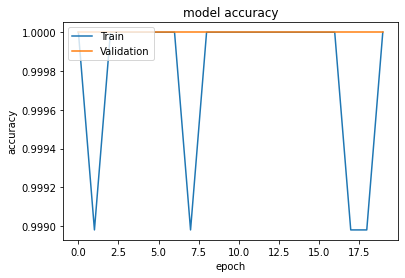

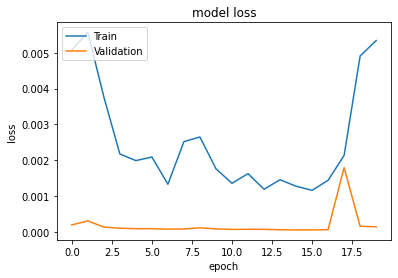

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\{}_acc.png".format(location, file_name, file_name))
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\{}_loss.png".format(location, file_name, file_name))
plt.show()


Visualize Model

In [20]:
# plot model
import visualkeras
from tensorflow.keras.utils import plot_model
plot_model(model, "F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\{}_plot_model.png".format(location, file_name, file_name), show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


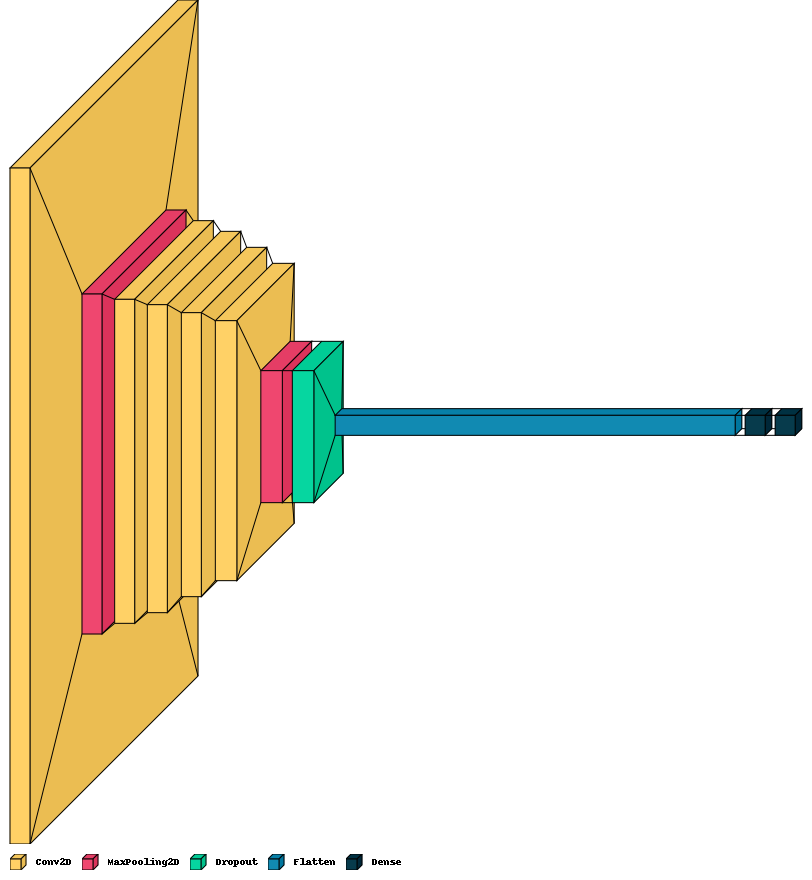

In [21]:
visualkeras.layered_view(model, "F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\{}_model.png".format(location, file_name, file_name), legend=True)

# Test Evaluation

In [22]:
# load trained model
file_name = 'm3_130x173_512x16_DATASET_3'
location = 'final'
model = tf.keras.models.load_model('F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\'.format(location, file_name))

In [23]:
x_test, y_test,_ = data_loader.get_test_data()
#test = h5py.File('E:\\current\\hdf5\\final\\raw_test.hdf5', 'r')
# x_test = test['frames'][:]
# y_test = test['contact'][:]
# test.close()
# print(x_train.shape)
x_test = resize_images(x_test, n_channels=3)
# print(x_test.shape)

(197, 130, 173, 3)


Confusion Matrix, Mean&Max Error

In [24]:
print(x_test.shape)

(197, 130, 173, 3)


(197, 130, 173, 3)


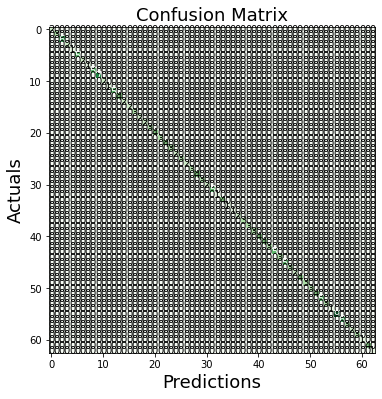

In [25]:
## IN TERMS OF CLASSES
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# predict the labels from test data
print(x_test.shape)
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
    
# The confusion matrix made from the real Y values and the predicted Y values
cf_matrix = confusion_matrix(y_true, y_pred_class)
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.savefig("F:\\ku.ac.ae\\Intelligent Robotic Manufacturing - Documents\\codes\\Visuotactile sensor\\contact_est\\{}\\{}\\{}_cf_matrix.png".format(location, file_name, file_name))
plt.show()


In [26]:
# # change from classes to deg
# def xy_deg(class_):
#     switcher = {
#         0: [0, 0], # what to do with no contact case ??
#         1: [0, 0],
#         2: [0.053033008588991064, 0.05303300858899106],
#         3: [0.10606601717798213, 0.10606601717798211],
#         4: [4.592425496802574e-18, 0.075],
#         5: [9.184850993605149e-18, 0.15],
#         6: [-0.05303300858899106, 0.053033008588991064],
#         7: [-0.10606601717798211, 0.10606601717798213],
#         8: [-0.075, 9.184850993605149e-18],
#         9: [-0.15, 1.8369701987210297e-17],
#         10: [-0.05303300858899108, -0.05303300858899106],
#         11: [-0.10606601717798216, -0.10606601717798211],
#         12: [-1.3777276490407722e-17, -0.075],
#         13: [-2.7554552980815445e-17, -0.15],
#         14: [0.05303300858899105, -0.05303300858899108],
#         15: [0.1060660171779821, -0.10606601717798216],
#         16: [0.075, -1.8369701987210297e-17],
#         17: [0.15, -3.6739403974420595e-17]
#     }
#     return switcher.get(class_)

# y_pred_xy = []
# for i in y_pred_class:
#     y_pred_xy.append(xy_deg(y_pred_class[i]))

# y_true_xy = []
# for i in y_true:
#     y_true_xy.append(xy_deg(y_true[i]))

# angle_error = []
# for i in range(len(y_true)):
#     diff_x = np.absolute(y_pred_xy[i][0] - y_true_xy[i][0])
#     diff_y = np.absolute(y_pred_xy[i][1] - y_true_xy[i][1])
#     angle_diff = np.sqrt(np.square(diff_x) + np.square(diff_y))
#     angle_error.append(angle_diff)


# max_error = max(angle_error)
# print ('maximum error in rad: {:.4f}'.format(max_error))

# mean_error = np.mean(angle_error)
# print ('mean error in rad: {:.4f}'.format(mean_error))

maximum error in rad: 0.0000
mean error in rad: 0.0000


In [26]:
# change from classes to deg
def xy_deg(class_):
    switcher = {
        0: [0, 0], # what to do with no contact case ??
        1: [0, 0],
        2: [0.01234134148078231, 0.01234134148078231],
        3: [0.02468268296156462, 0.02468268296156462],
        4: [0.03702402451305761, 0.03702402451305761],
        5: [0.053033008588991064, 0.053033008588991064],
        6: [0.06717514421272203, 0.06717514421272203],
        7: [0.08131727983645297, 0.08131727983645297],
        8: [0.09545941546018392, 0.09545941546018392],
        9: [0.10606601717798213, 0.10606601717798213],
        10: [1.0687059397353753e-18, 0.0174532925],
        11: [2.1374118794707506e-18, 0.034906585],
        12: [3.2061178253293598e-18, 0.0523598776],
        13: [4.592425496802574e-18, 0.075],
        14: [5.817072295949928e-18, 0.095],
        15: [7.04171909509728e-18, 0.115],
        16: [8.266365894244634e-18, 0.135],
        17: [9.184850993605149e-18, 0.15],
        18: [-0.012341341480782309, 0.01234134148078231],
        19: [-0.024682682961564617, 0.02468268296156462],
        20: [-0.037024024513057606, 0.03702402451305761],
        21: [-0.05303300858899106, 0.053033008588991064], 
        22: [-0.06717514421272201, 0.06717514421272203], 
        23: [-0.08131727983645295, 0.08131727983645297], 
        24: [-0.09545941546018391, 0.09545941546018392], 
        25: [-0.10606601717798211, 0.10606601717798213], 
        26: [-0.0174532925, 2.1374118794707506e-18], 
        27: [-0.034906585, 4.274823758941501e-18], 
        28: [-0.0523598776, 6.4122356506587196e-18], 
        29: [-0.075, 9.184850993605149e-18], 
        30: [-0.095, 1.1634144591899856e-17], 
        31: [-0.115, 1.408343819019456e-17], 
        32: [-0.135, 1.653273178848927e-17], 
        33: [-0.15, 1.8369701987210297e-17], 
        34: [-0.012341341480782312, -0.012341341480782309], 
        35: [-0.024682682961564624, -0.024682682961564617], 
        36: [-0.03702402451305762, -0.037024024513057606], 
        37: [-0.05303300858899108, -0.05303300858899106], 
        38: [-0.06717514421272203, -0.06717514421272201], 
        39: [-0.08131727983645298, -0.08131727983645295], 
        40: [-0.09545941546018394, -0.09545941546018391], 
        41: [-0.10606601717798216, -0.10606601717798211], 
        42: [-3.2061178192061255e-18, -0.0174532925],
        43: [-6.412235638412251e-18, -0.034906585], 
        44: [-9.618353475988079e-18, -0.0523598776],
        45: [-1.3777276490407722e-17, -0.075],
        46: [-1.745121688784978e-17, -0.095],
        47: [-2.1125157285291842e-17, -0.115], 
        48: [-2.4799097682733903e-17, -0.135],
        49: [-2.7554552980815445e-17, -0.15], 
        50: [0.012341341480782307, -0.012341341480782312], 
        51: [0.024682682961564614, -0.02468268296156462], 
        52: [0.0370240245130576, -0.03702402451305762], 
        53: [0.05303300858899105, -0.05303300858899108], 
        54: [0.067175144212722, -0.06717514421272203], 
        55: [0.08131727983645295, -0.08131727983645298], 
        56: [0.0954594154601839, -0.09545941546018394], 
        57: [0.1060660171779821, -0.10606601717798216], 
        58: [0.0174532925, -4.274823758941501e-18], 
        59: [0.034906585, -8.549647517883002e-18], 
        60: [0.0523598776, -1.2824471301317439e-17], 
        61: [0.075, -1.8369701987210297e-17], 
        62: [0.095, -2.3268289183799712e-17], 
        63: [0.115, -2.816687638038912e-17], 
        64: [0.135, -3.306546357697854e-17], 
        65: [0.15, -3.6739403974420595e-17]
    }
    return switcher.get(class_)

y_pred_xy = []
for i in y_pred_class:
    y_pred_xy.append(xy_deg(y_pred_class[i]))

y_true_xy = []
for i in y_true:
    y_true_xy.append(xy_deg(y_true[i]))

angle_error = []
for i in range(len(y_true)):
    diff_x = np.absolute(y_pred_xy[i][0] - y_true_xy[i][0])
    diff_y = np.absolute(y_pred_xy[i][1] - y_true_xy[i][1])
    angle_diff = np.sqrt(np.square(diff_x) + np.square(diff_y))
    angle_error.append(angle_diff)


max_error = max(angle_error)
print ('maximum error in rad: {:.4f}'.format(max_error))

mean_error = np.mean(angle_error)
print ('mean error in rad: {:.4f}'.format(mean_error))

maximum error in rad: 0.0000
mean error in rad: 0.0000


In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)

7/7 [==============================] - 1s 18ms/step - loss: 2.2137e-04 - accuracy: 1.0000


Prediction: [-0.095, 1.1634144591899856e-17]
Actual: [-0.095, 1.1634144591899856e-17]


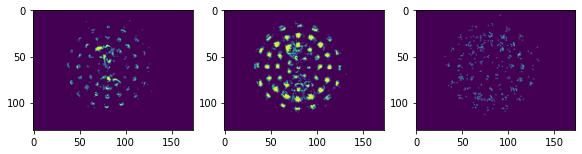

29
Prediction: [-0.012341341480782312, -0.012341341480782309]
Actual: [-0.012341341480782312, -0.012341341480782309]


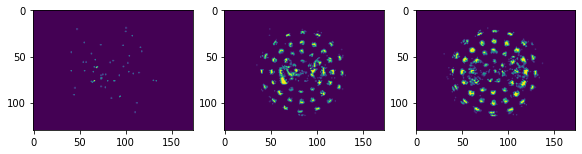

154
Prediction: [-0.10606601717798216, -0.10606601717798211]
Actual: [-0.10606601717798216, -0.10606601717798211]


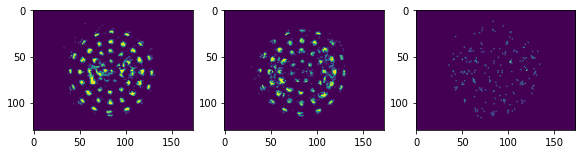

69
Prediction: [0.10606601717798213, 0.10606601717798213]
Actual: [0.10606601717798213, 0.10606601717798213]


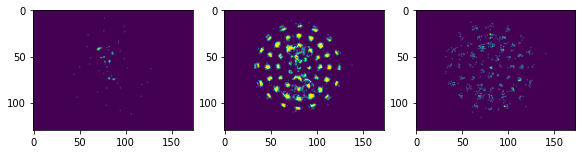

6
Prediction: [0, 0]
Actual: [0, 0]


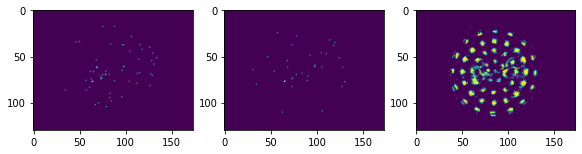

131
Prediction: [0.135, -3.306546357697854e-17]
Actual: [0.135, -3.306546357697854e-17]


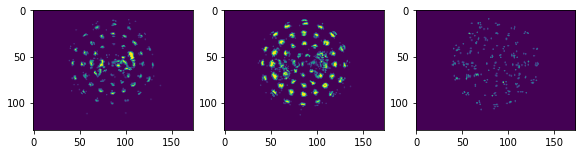

102
Prediction: [-0.034906585, 4.274823758941501e-18]
Actual: [-0.034906585, 4.274823758941501e-18]


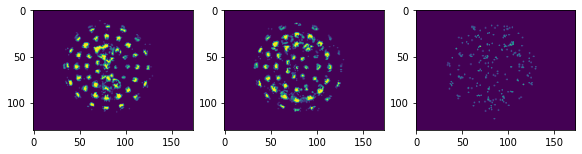

135
Prediction: [-0.095, 1.1634144591899856e-17]
Actual: [-0.095, 1.1634144591899856e-17]


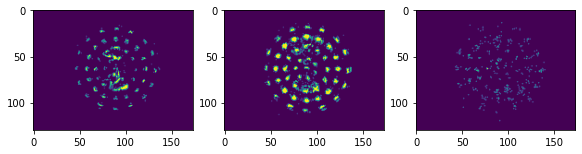

140


In [29]:
for i in range(8):   
# if True: 
    sample_id = np.random.randint(0, x_test.shape[0])
    
    predictions = [y_pred_xy[sample_id][0], y_pred_xy[sample_id][1]] #y_pred[sample_id]

    actual = [y_true_xy[sample_id][0], y_true_xy[sample_id][1]]

    print('Prediction:', predictions)
    print('Actual:', actual)

    # plot the sample image
    fig=plt.figure(figsize=(20, 20))
    rows = 1
    columns = 6
    for ii in range(0, 3):
        fig.add_subplot(rows, columns, ii+1)
        plt.imshow(x_test[sample_id,:,:,ii].reshape(130,173, 1))
    plt.show()
    # plt.imshow(x_train_resized[sample_id,:,:,1].reshape(130,173, 1))
    # plt.show()

    # x.append((y_pred[predicted_class][0]-y_test[predicted_class][0])*180/np.pi)
    # y.append((y_pred[predicted_class][1]-y_test[predicted_class][1])*180/np.pi)
    print(sample_id)